<a href="https://colab.research.google.com/github/liane886/StartGNN_cw/blob/main/a1_node_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment1: Node Embedding

Graph embedding aims to map each node in a given graph into a low-dimensional vector representation. By looking at nodes in the embedding space, we are able to mining information such as data clusters and links between nodes. \
In this assignment, we are focusing on the task of node clustering. First, you will answer 2 questions regarding traditional graph features. Secondly, you will implement Node2Vec, an automatic feature learning method that preserves both local and global graph information. At last, you will apply learned embeddings to clustering tasks and visualize the embeddings. \
Please follow the instructions below, filling in codes snippets and answering questions.

## Environment

In [6]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.cluster import KMeans

## Graph setup

In this assignment, we use character relationship graph from the book *Les Miserables* by *Victor Hugo*.
Nodes in this graph correspond to 77 characters, while edges indicate the co-occurrance of two characters in the novel. 

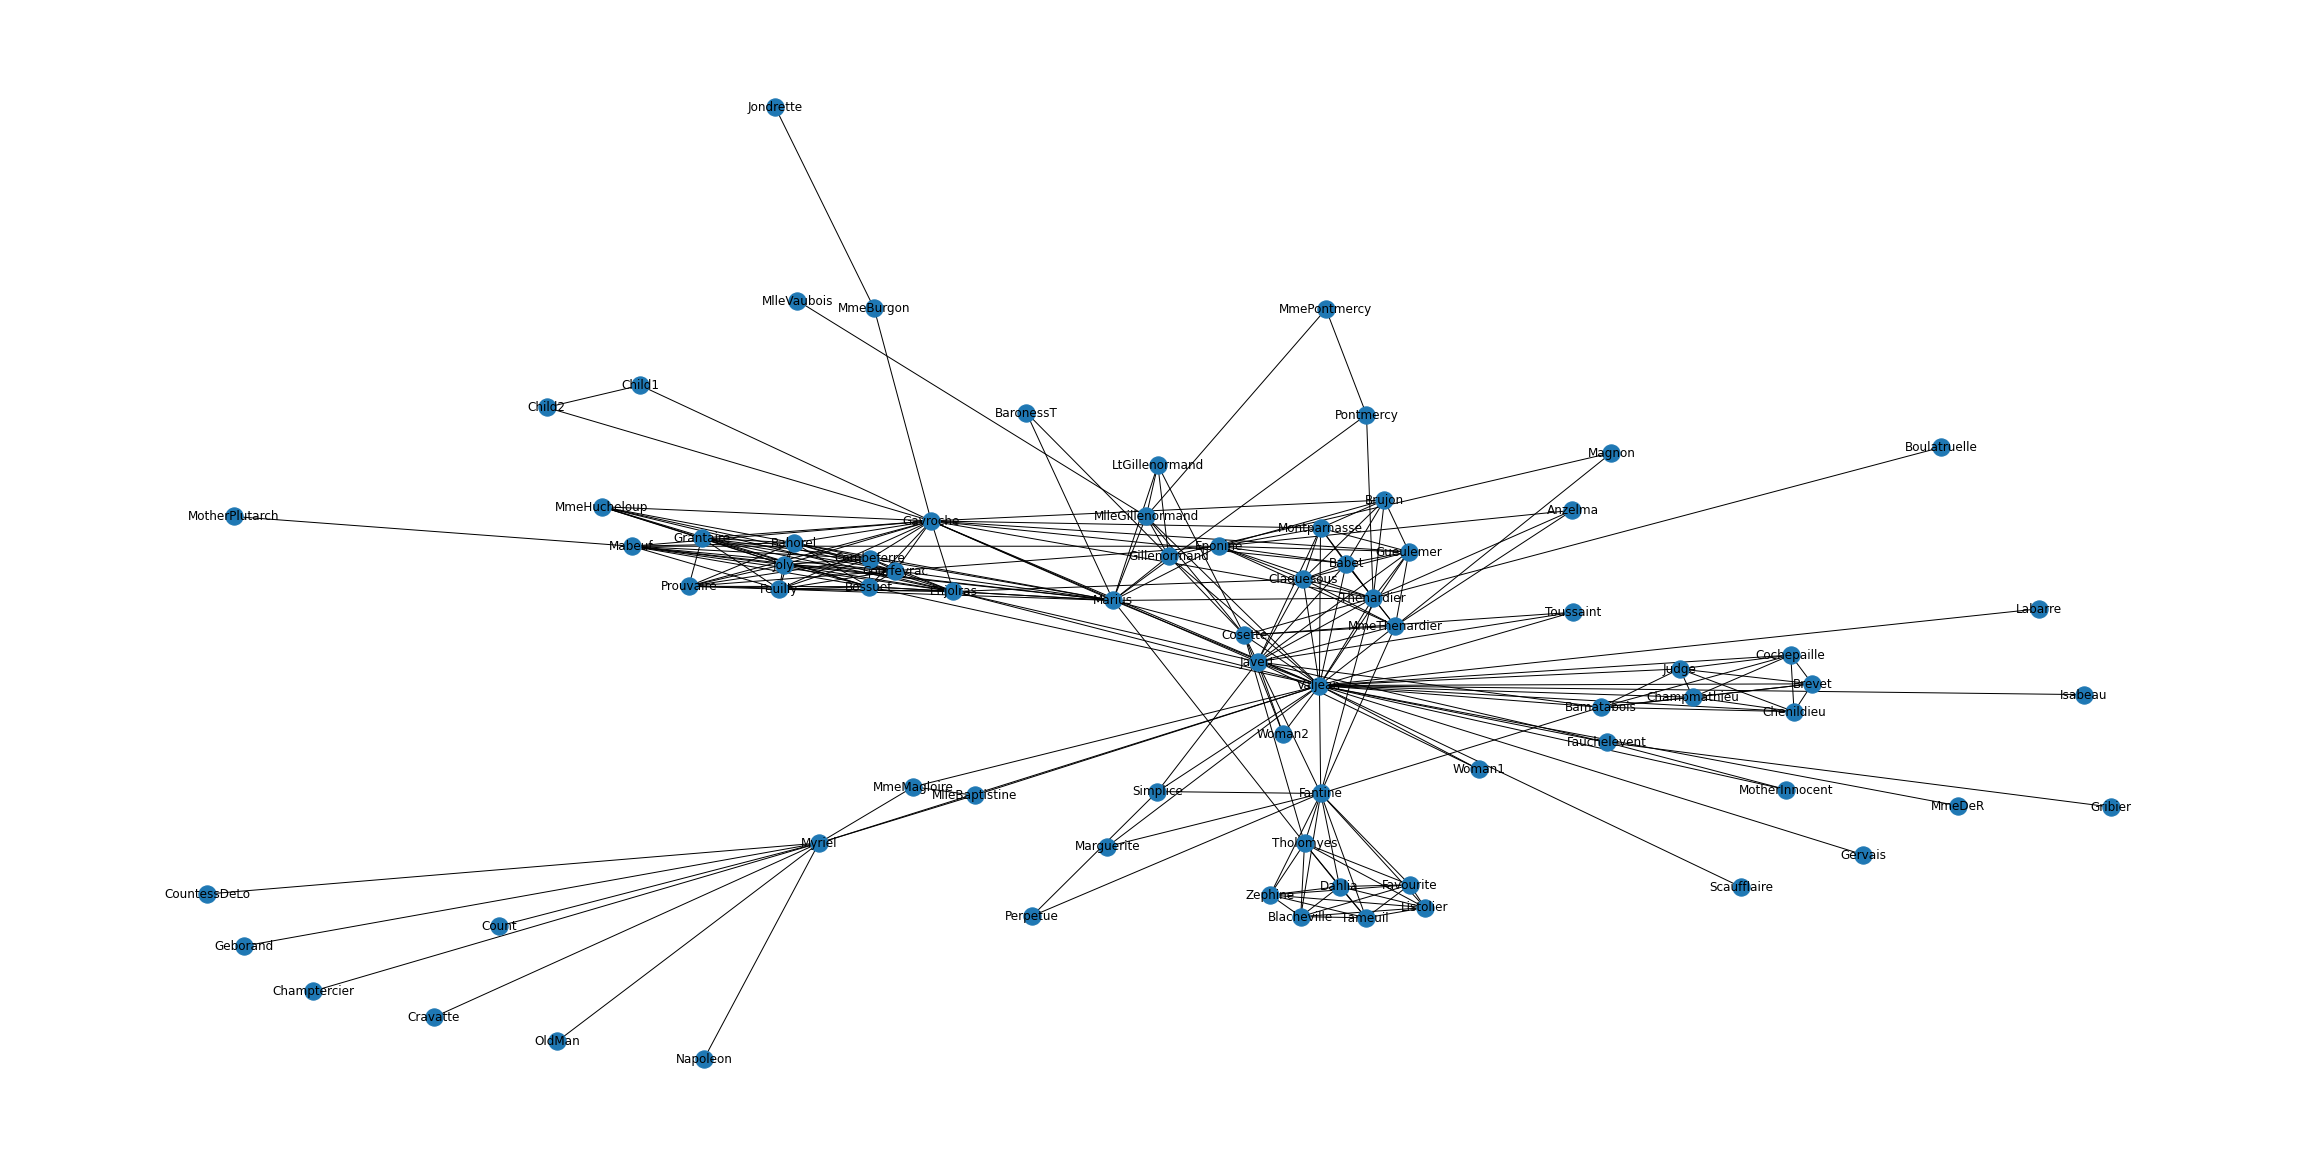

In [24]:
G = nx.les_miserables_graph()
# visualize graph
plt.figure(figsize=(32,16))
nx.draw(G, with_labels = True)

The *Les Miserables* graph has weighted edges. For convenience, we will only use the graph topology, and set edge weights all equal to 1.

In [25]:
for u, v, d in G.edges(data=True):
    d['weight'] = 1

Since node is marked by string form name in this graph, we should first tokenize nodes to indexs. You might use this function in later tasks.

In [22]:
def tokenize(G):
    nodes_list = list(G.nodes)
    name2id = {v: idx for idx, v in enumerate(G.nodes)}
    id2name = {idx: v for idx, v in enumerate(G.nodes)}
    return name2id, id2name

In [26]:
name2id, id2name = tokenize(G)

## Node Level Feature

First, let's implement the function to calculate node degree.

### 1. (5 point) Node Degree

In [53]:
def deg(G, u):
    # Calculate the degree of u
    
    # G: networkx graph
    # u: node name in G
    
    ### your code here
    degrees = {node:val for (node, val) in G.degree()}
    degree = degrees[u]
    #
    ###
    return degree

print(deg(G, 'Marius'))

19


---

Below, we visualize node degree centrality. Brighter color indicates higher centriality, while darker ones indicates lower centriality. \
You may learn who is the main character of *Les Miserables* by looking at the brightest node in degree centrality graph! 

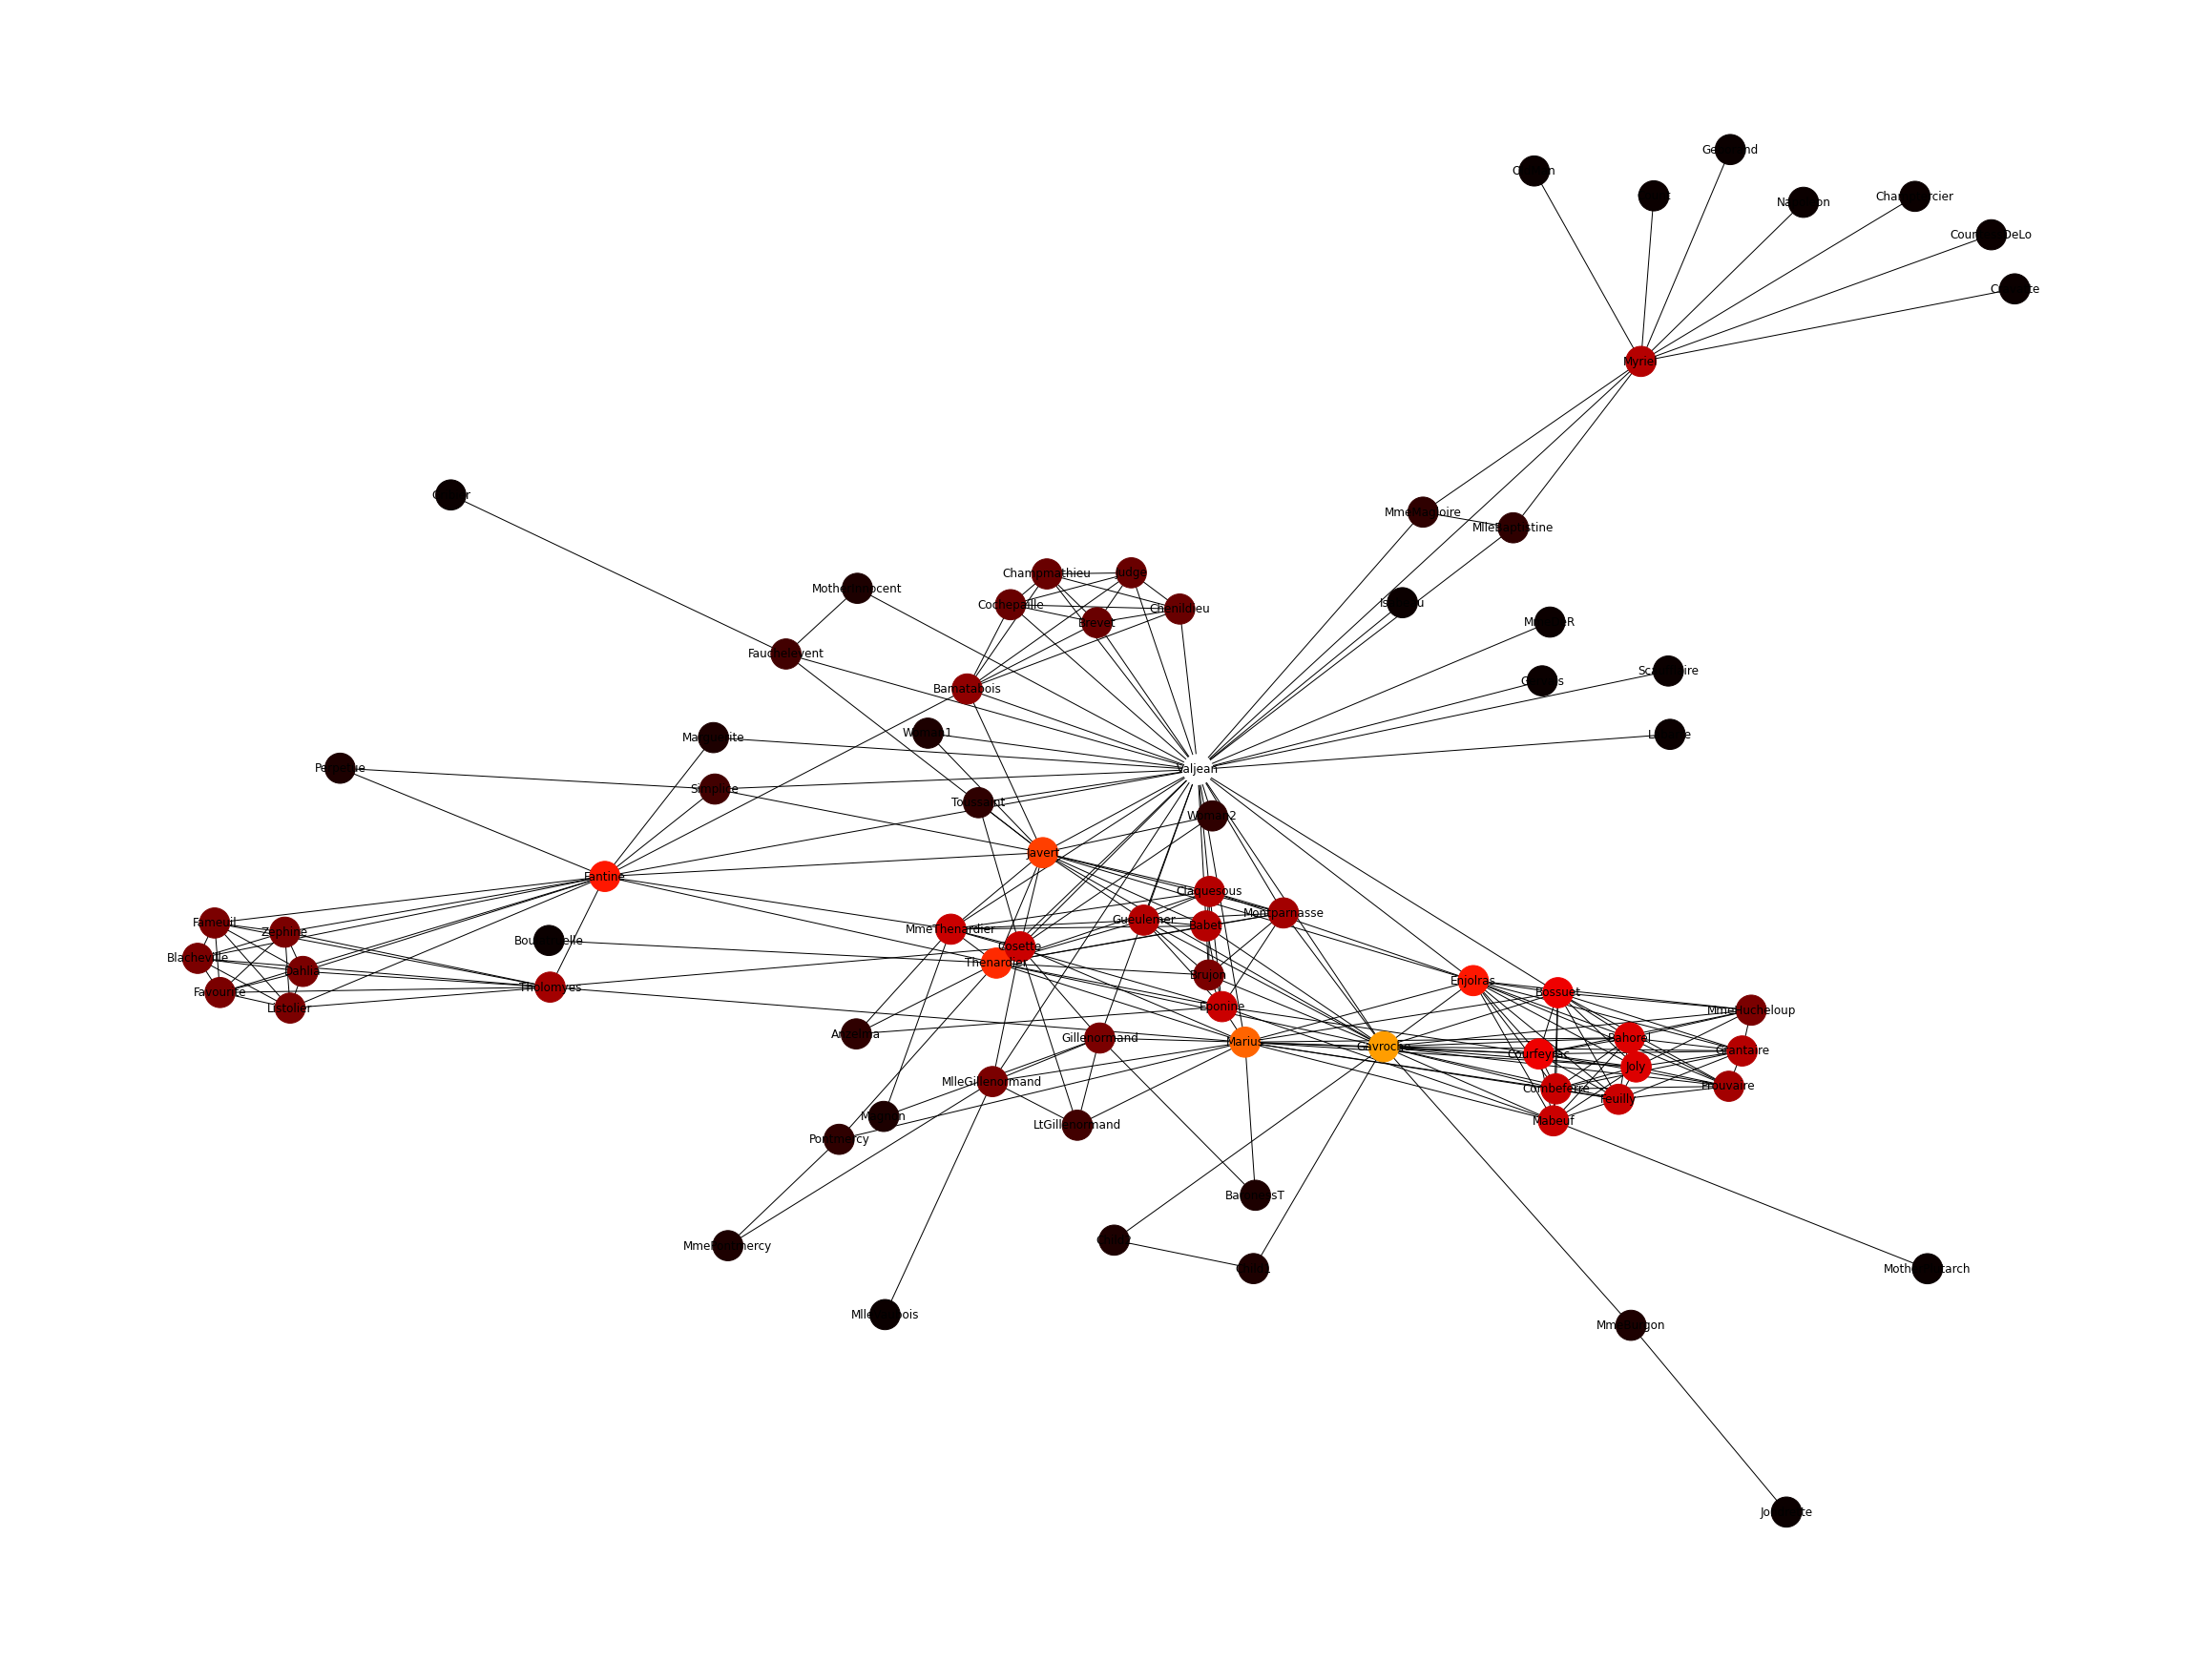

In [54]:
# Visualize node degree centriality
degrees = [deg(G, u) for u in G.nodes]
plt.figure(figsize=(32,24))
nx.draw(G, pos=nx.spring_layout(G, seed=20), node_color=degrees, node_size=1000, cmap=plt.cm.hot, with_labels=True)

## Link Level Feature

*If you lie down with dogs, you get up with fleas -- Anonymous* \
\
Local overlap statistics measures nodes similarity by quantifying the overlap between node neighborhoods. These similarity measures can be further used to infer potential relationships betweeen nodes. Please implement functions to calculate jaccard coefficient below and print correct answer.

### 2. (10 points) Jaccard Coefficients

In [55]:
def jaccard(G, node1, node2):
    # Calculate jaccard coefficient between node1 and node2
    # Please do not directly use nx.jaccard_coefficient
    
    # G: networkx graph
    # node1: node 1 name
    # node2: node 2 name
    
    #### your code here
    neigh1 = [u for u in G.neighbors(node1)]
    neigh2 = [u for u in G.neighbors(node2)]
    intersection = len(list(set(neigh1).intersection(neigh2)))
    union = (len(neigh1) + len(neigh2)) - intersection
    jaccard_coefficient =  float(intersection)/union
    #
    ###
    return jaccard_coefficient

# ===test===
j1 = jaccard(G, 'Cosette', 'Marius')
j2 = jaccard(G, 'Valjean', 'Javert')

print('Cosette--Marius: ', j1)
print('Valjean--Javert: ', j2)

Cosette--Marius:  0.25
Valjean--Javert:  0.43243243243243246


## Node2Vec

Node2Vec is an optimization-based method to calculate node embedding. The key insight behind this approach is that nodes should be optimized towards similar embedding if they co-occur on a short random walk over the graph. \
Node2Vec basically consists of the following modules:
1. Encode function: generates the node embedding
2. Decode function: reconstructs pairwise similarity
3. Similarity function: measures the similarity between nodes (For node2vec, the similarity measure is node co-occurrence within a walk)
4. Loss function: checks the quality of the reconstruction
![](https://raw.githubusercontent.com/stellaloudai/AIAA5028_ML4GNN/main/n2v.png)

### 3. (20 points) Random Walk

A random walk starts from a given node, and randomly walks to a neighbour node so as to generate a sequence of related nodes. If the edges are weighted, the neighbour is sampled with respect to probability propotional to weights of the edges. \
As for node2vec, in each walk step, the edges are weighted to balance BFS and DFS exporation. BFS encodes local information, while DFS encodes global information.
Suppose current node is u. Then the weights between u and its neighbor v can be decided as follows:

\begin{equation}
\text{Weight}(u, v) = 
\begin{cases}
\frac{1}{p}, & \text{if v is previous node}; \\
1, & \text{if v is a neighbor of previous node};\\
\frac{1}{q}, & \text{elsewise}
\end{cases}
\end{equation}

where $p$ is the return parameter and $q$ is the in-out parameter. \
We implemented the ***random_walk*** function for you as below. To answer the question, you are required to implement single node2vec random walk step as instructed in function ***one_walk_step***.

In [56]:
# random walk

def random_walk(G, u, walk_length, p, q):
    walks = []

    # Start the walk with a random node from the graph.
    walk = [u]
    # Randomly walk for num_steps.
    while len(walk) < walk_length:
        cur = walk[-1]
        prev = walk[-2] if len(walk) > 1 else None
        # Compute the next node to visit.
        nxt = one_walk_step(G, prev, cur, p, q)
        walk.append(nxt)

    return walk

def one_walk_step(G, prev, cur, p, q):
    # One step of node2vec random walk: sample next node according to p and q.
    
    # G: networkx graph
    # prev: previous node name in G
    # cur: current node name in G
    # p: return parameter
    # q: in-out parameter
    # You should return the name of next node to go.
    
    ###your code here

    def alias_sampling(probs):
      '''
      Compute utility lists for non-uniform sampling from discrete distributions.
      Refer to https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
      for details
      '''
      K = len(probs)
      q = np.zeros(K)
      J = np.zeros(K, dtype=np.int)

      smaller = []
      larger = []
      for kk, prob in enumerate(probs):
          q[kk] = K*prob
          if q[kk] < 1.0:
              smaller.append(kk)
          else:
              larger.append(kk)

      while len(smaller) > 0 and len(larger) > 0:
          small = smaller.pop()
          large = larger.pop()

          J[small] = large
          q[large] = q[large] + q[small] - 1.0
          if q[large] < 1.0:
              smaller.append(large)
          else:
              larger.append(large)

      return J, q

    def alias_draw(J, q):
      '''
      Draw sample from a non-uniform discrete distribution using alias sampling.
      Refer to https://github.com/aditya-grover/node2vec/blob/master/src/node2vec.py 
      '''
      K = len(J)

      kk = int(np.floor(np.random.rand()*K))
      if np.random.rand() < q[kk]:
          return kk
      else:
          return J[kk]
    
    
    unnormal_prob = []
    nbr_ls = sorted(G.neighbors(cur))
    for cur_nbr in nbr_ls:
    # n_G[cur]['prob'] = dict()
    # try:
    #   if G[cur][pre].get('weight'):
    #     weight = G[cur][pre].get('weight' 1)
    #   else: 
    #     edge = list(G[current_node][pre])[-1]
    #     weight = G[cur][pre][edge].get('weight', 1)
    # except:
      weight = 1.0
      if cur_nbr == prev:
        unnormal_prob.append(weight/p)
      elif G.has_edge(cur_nbr, prev):
        unnormal_prob.append(weight*1)
      else:
        unnormal_prob.append(weight/q)

    # nomalize the probability 
    norm_const = sum(unnormal_prob)
    normal_prob = [float(u_p)/norm_const for u_p in unnormal_prob] 

    alis_J,alis_q = alias_sampling(normal_prob)
    indx = alias_draw(alis_J,alis_q)
    nxt = nbr_ls[indx]
    return nxt



Below is a test for your function ***one_walk_step***. If your code is correct, the final output should have values **around(not exactly, since we are using limited samples to estimate probability)**:

s1: 0.18 \
s2: 0.09 \
s3: 0.36 \
s4: 0.36


s1:0.2
s2:0.1
s3:0.4
s4:0.3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


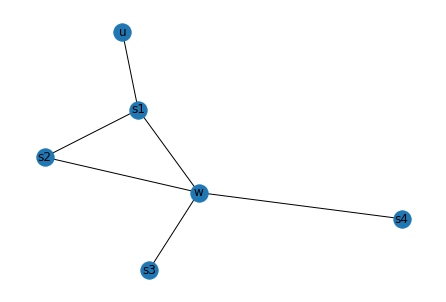

In [19]:
test_G = nx.Graph()
test_G.add_edge('w', 's1')
test_G.add_edge('w', 's2')
test_G.add_edge('w', 's3')
test_G.add_edge('w', 's4')
test_G.add_edge('s1', 's2')
test_G.add_edge('s1', 'u')

nx.draw(test_G, pos=nx.spring_layout(test_G, seed=20), with_labels=True)

# sample_num = 10000
sample_num = 10
prev = 's1'
cur = 'w'
p = 0.5
q = 0.25

results = {k:0 for k in test_G.neighbors(cur)}
for i in range(sample_num):
    nxt = one_walk_step(test_G, prev, cur, p, q)
    results[nxt] += 1


for k,v in results.items():
    print('{}:{}'.format(k, v/sample_num))

---

### 4. (20 points) Negative Sampling

Our goal is to maximize the co-occurring probability of nodes u and v, which can be formulated as:
\begin{equation}
P=\sum_{u \in V}\sum_{v \in N_R(u)}\log{\left(\frac{e^{z_u^Tz_v}}{\sum_{n \in V}e^{z_u^Tz_n}}\right)}
\end{equation}
However, normalizing the probability across all nodes are expensive. For computational efficiency, the partition function(denominator in the above equation) can be estimated by several negative samples, which can be written as follows:
\begin{equation}
P=\log{\left(\sigma(z_u^Tz_v)\right)} - \sum_{i=1}^k\log{\left(\sigma(z_u^Tz_{n_i})\right)}
\end{equation}
Where $\{n_i\}, 0 \leq i < k$ are the negative samples. 
Please implement the negative sampling function below.

In [73]:
def negative_sampling(G, walk, k, id2name, name2id):
    # Suppose start node of walk is u. Sampling k nodes which are neither on the walk nor adjacent to u.
    
    # G: networkx graph
    # walk: list of node names. A random walk,
    # k: number of negative samples
    # id2name: a dictionary with key being node index and value being node name.(refer to previous tokenize function)
    # name2id: a dictionary with key being node name and value being node index.(refer to previous tokenize function)
    
    # You should return a list consists of k node name.
    
    ####your code here
    adj = list(G.neighbors(walk[0]))
    pos = list(set(walk + adj))
    neg_ls = [i for i in list(G.nodes) if i not in pos] 
    
    sample_negs = np.random.choice(neg_ls, k).tolist()
    
    return sample_negs

Below is a test for function negative sampling. If your implementation is correct, the output should look like: \
['s3', 's4']

In [76]:
test_walk=['s2', 's1', 'u']
name2id_test, id2name_test = tokenize(test_G)
neg_nodes = negative_sampling(test_G, test_walk, 10, id2name_test, name2id_test)
neg_nodes = np.unique(neg_nodes)
print(neg_nodes)

['s3' 's4']


---

Now we collect data by random walks to form training dataset.

In [75]:
# get data
data = []
num_walks = 100
walk_length = 5
k=5
p=1
q=0.5

for walk_iter in tqdm(range(num_walks)):
    nodes = list(G.nodes)
    random.shuffle(nodes)
    for n in nodes:
        w = random_walk(G, n, walk_length, p, q)
        nw = negative_sampling(G, w, k=k, id2name=id2name, name2id=name2id)
        x = w + nw
        x = [name2id[i] for i in x]
        pos_labels = np.ones(len(w)-1) # except for start node
        neg_labels = np.zeros(len(nw))
        labels = np.concatenate([pos_labels, neg_labels], axis=0) # walk_length + k
        data.append({'u': x[0], 'vs': x[1:], 'labels': labels})
        
class N2VDataset(Dataset):
    def __init__(self, data):
        super(N2VDataset).__init__()
        self.data = data
          
    def __len__(self):
        return len(self.data)    
        
    def __getitem__(self, idx):
        d = self.data[idx]
        return torch.tensor(d['u']).long(), torch.tensor(d['vs']).long(), torch.tensor(d['labels']).float()

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 100/100 [00:02<00:00, 42.45it/s]


## Learn Node Embedding

The final step is to train node embedding. We try to minimize the loss function below:
\begin{equation}
L = -\log{\left(\sigma({z_u}^Tz_v)\right)} + \sum_{i=1}^k\log{\left(\sigma({z_u}^Tz_{n_i})\right)}
\end{equation}
which can be efficiently implemented with ***binary cross entropy(BCE)*** loss. \
Besides, we use ***Stocastic Gradient Descent(SGD)*** to optimize our model.
Please follow the instruction below and implement the code.

### 5. (10 points) Predict Similarity

The forward pass of node2vec model aims to predict the similarity between two nodes. To be specific, the similarity between node $u$ and $v$ is:
\begin{equation}
\text{Similarity} = {z_u}^Tz_v
\end{equation}
where $z_u$ is the embedding for node $u$.
Please implement the forward pass in node2vec model.

In [198]:
from re import U
class Node2Vec(nn.Module):
    def __init__(self, G):
        super().__init__()
        self.G = G
        self.embedding = nn.Embedding(num_embeddings=len(G.nodes), embedding_dim=16)
    
    def forward(self, u, vs):
        # Calculate the similarity between node u and a list of nodes vs.
        
        # u: tensor, (batch_size, ). start node
        # vs: tensor,(batch_size, walk_length -1 + k). a list of nodes including nodes within a walk(positive examples) and outside of walk(negative examples).
        
        # You should return a tensor of size (batch_size, len(vs)) with each entry indicates the similarity between u and each v from vs.
        
        
        ### your code here
        u_emb = self.embedding(u).unsqueeze(1)
        u_emb_trans = u_emb.transpose(1,2)
        vs_emb = self.embedding(vs)
        similarity = torch.matmul(vs_emb,u_emb_trans).reshape(len(u),len(vs[0]))
        # similarity = torch.matmul(u_emb,vs_emb.transpose(1,2))
        return similarity

Below is a test for your Node2Vec model. If your implementation is correct, your output should looks like this: \
tensor([[ 3160.,  5080.,  7000.], \
        [ 3160., 15192., 27224.]])

In [199]:
test_model = Node2Vec(test_G)

test_weight = torch.arange(16 * len(test_G.nodes)).reshape(-1, 16).float()
test_model.embedding = nn.Embedding.from_pretrained(test_weight)

u = torch.tensor([0,1]).long()
vs = torch.tensor([[1,2,3], [0,2,4]]).long()

sim = test_model.forward(u, vs)
print(sim)

tensor([[ 3160.,  5080.,  7000.],
        [ 3160., 15192., 27224.]])


---

### 6. (20 points) Train Embedding

Now, you're ready to implement a typical model training process using pytorch. Follow the instruction below and train node embedding.

In [221]:
model = Node2Vec(G)
dataset = N2VDataset(data)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.2, weight_decay=0.001)
num_epochs = 200

def train(num_epochs, model, dataloader, optimizer):
    # Train node embedding. The training mainly consists of the following step:
    

    # 1. Get a batch of data from dataloader.
    # 2. Feed the data to node2vec model and get similarity between start node u and rest nodes.
    # 3. Compute the binary cross entropy loss between predicted similarity and labels.
    # 4. Backpropagate loss.
    # 5. Update parameters.
    
    # hint:
    # 1. You can use BCELoss from torch.nn(Don't forget the sigmoid part).
    # 2. Above step should be repeated for every batch in dataloader in each epoch. Total epoch is num_epochs.
    
    ### your code here
    for i in range(num_epochs):
      for u,vs,label in dataloader:
        optimizer.zero_grad()
        out = model(u,vs)
        sig = nn.Sigmoid()
        loss = nn.BCELoss()
        output = loss(sig(out), label)
        output.backward()
        optimizer.step()
    return
train(num_epochs, model, dataloader, optimizer)

## Visualize Embedding

## Application: Graph Clustering

Now, we can cluster the nodes by their embeddings. We first use k-means to cluster nodes to 6 clusters. Then, we assign color to a node based on its cluster. By looking at whether similar nodes are assigned similar colors, we can learn whether the model successfully put similar nodes to near positions in embedding space. \
If there is no homophily presented in below representation at all, you might have to debug your code to get the points here. \
You might tune the hyperparameters such as walk length, p, q, k to observe different clustering results. \
Higher p and lower q typically prefers BFS to DFS, which makes the model tends to deem similarity as community. \
Higher q and lower p typically prefers BFS to DFS, which makes the model tends to deem similarity as structural role.

### 7. (10 points) Node2Vec Embedding Homophily

You don't have to implement any code here. You will get the 10 points if graph homophily is clearly presented in the following visualization. To be specific, there should be at least 4 color clusters to prove your model has learn meaningful embeddings.

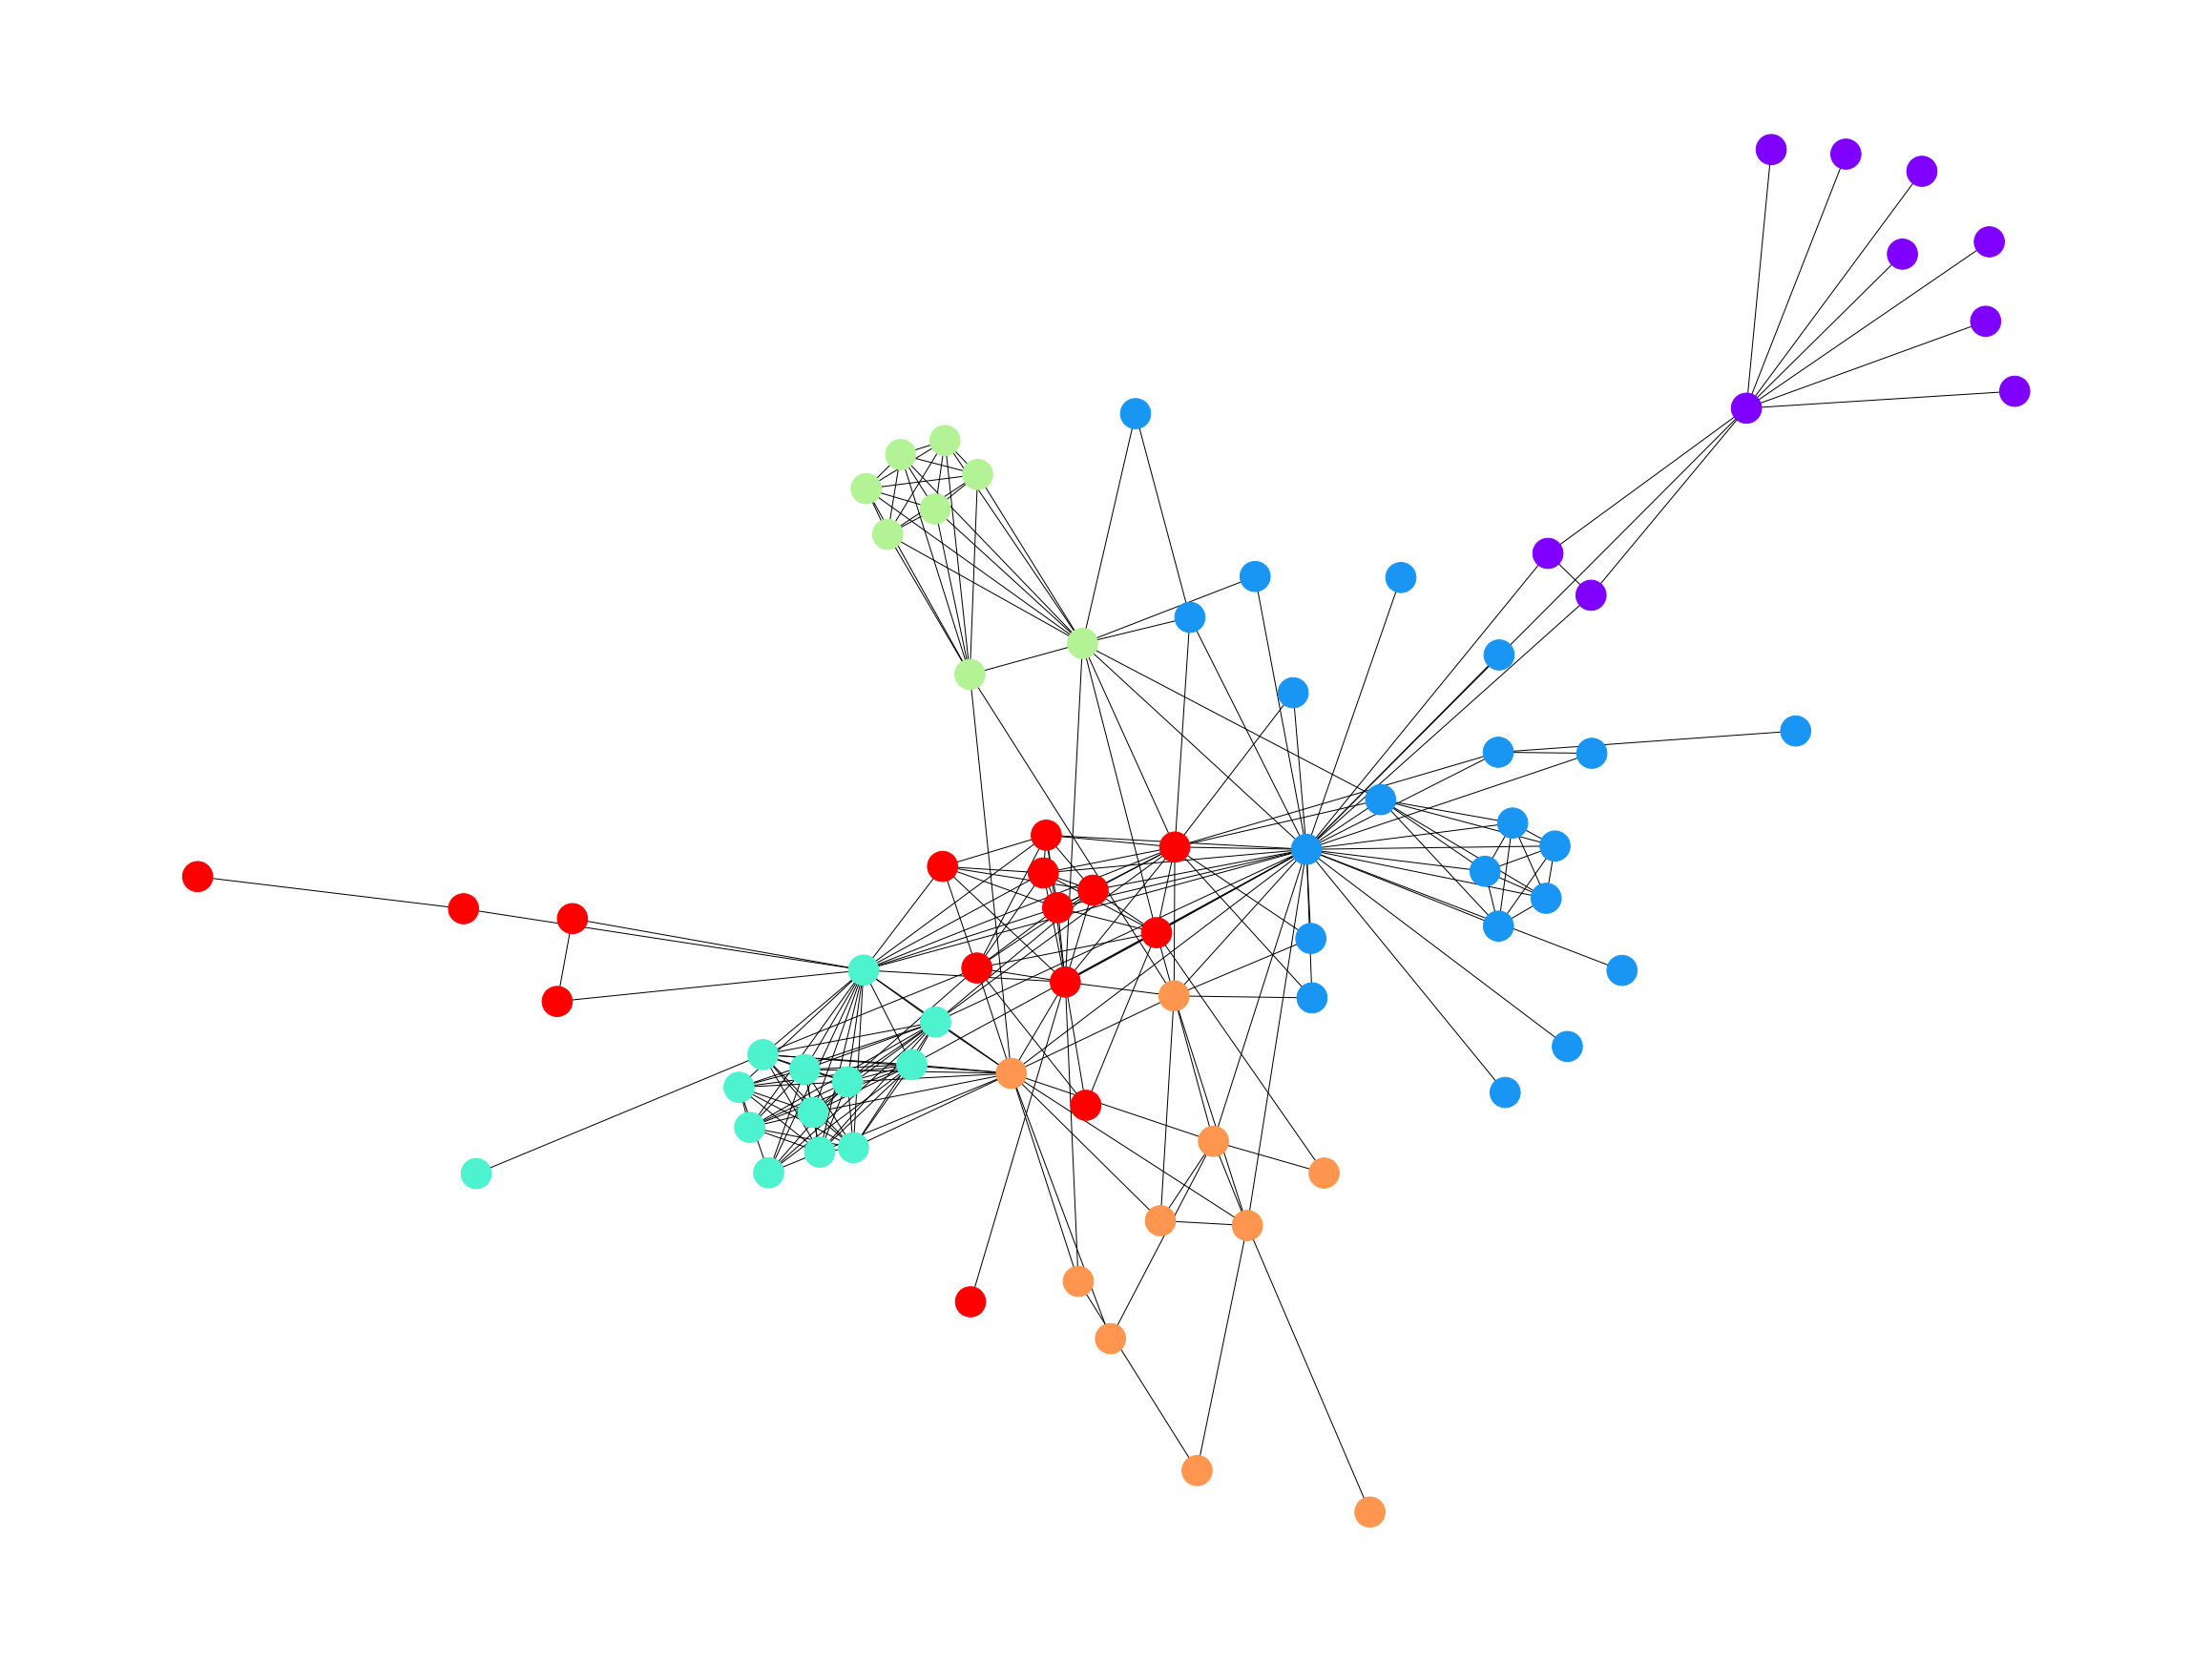

In [222]:
# get k-means clustering for 6 labels
node_embeddings=model.embedding.weight.data
kmeans_cluster = KMeans(n_clusters=6, init='k-means++').fit(node_embeddings)
kmeans_labels = kmeans_cluster.labels_

plt.figure(figsize=(32,24))
nx.draw(G, pos=nx.spring_layout(G, seed=10), node_color=kmeans_labels, node_size=1000, cmap=plt.cm.rainbow)